# Benchmarks of VM proving times made by Aligned

## Table of Contents

- [About](#About)
- [GPU Benchmarks on RTX A6000](#GPU-Benchmarks-on-RTX-A6000)
  - [Fibonacci Benchmark](#Fibonacci-Benchmark)
  - [Keccak Benchmark](#Keccak-Benchmark)
  - [RSP Benchmark](#RSP-Benchmark)
- [CPU Benchmarks on AMD EPYC 8534P 64-Core Processor](#CPU-Benchmarks-on-AMD-EPYC-8534P-64-Core-Processor)
  - [Fibonacci Benchmark](#Fibonacci-Benchmark)
  - [Keccak Benchmark](#Keccak-Benchmark)



## About

These benchmarks aim to provide a neutral suite for measuring the efficiency of zkVMs. 

The benchmarks test the following programs:

- ✅ Fibonacci
- ✅ Keccak
- 🏗️ [RSP (Reth Succinct Processor)](https://github.com/succinctlabs/rsp)

The benchmarks are run on the following zkVMs:

- [SP1](https://docs.succinct.xyz/docs/sp1/introduction)
- [Risc0](https://risczero.com/)
- [Pico](https://docs.brevis.network/)

You can run this Python notebook yourself to create new plots or analyze the data.

The Githbut repository is available [here](https://github.com/yetanotherco/zkvm_benchmarks).

Raw results can be found [here](https://github.com/yetanotherco/zkvm_benchmarks/tree/main/bench_results).

The full Jupyter notebook can be found [here](https://github.com/yetanotherco/zkvm_benchmarks/blob/main/benchmark.ipynb).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # Added for regression

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Constants
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
DARK_BG = '#1a1a1a'
GRID_ALPHA = 0.2
LEGEND_BG = '#2d2d2d'

## Some auxiliary functions

def time_to_seconds(time_str):
    time_str = time_str.strip()
    try:
        if 'm' in time_str:
            parts = time_str.split('m')
            minutes = float(parts[0])
            seconds = 0
            if len(parts) > 1 and parts[1]:
                seconds = float(parts[1].replace('s', ''))
            return minutes * 60 + seconds
        else:
            return float(time_str.replace('s', ''))
    except Exception as e:
        print(f"Error parsing time: {time_str}")
        print(f"Error details: {e}")
        return None
    

def load_data(input_csv_path):
    # Read data from CSV
    # Return DataFrame with columns for Seconds and Minutes
    df = pd.read_csv(input_csv_path)
    df['N'] = df['N'].astype(int)
    
    for idx, row in df.iterrows():
        seconds = time_to_seconds(row['Time'])
    
    df['Seconds'] = df['Time'].apply(time_to_seconds)
    df['Minutes'] = df['Seconds'] / 60
    return df

def print_dataframe(df):
    print("\nData sorted by Prover and N for validation:")
    pd.set_option('display.float_format', '{:.2f}'.format)
    validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
    print(validation_df.to_string())
    
def format_axis_numbers(value, _):
    """Format numbers in millions (M) or thousands (K) for axis labels."""
    if value >= 1_000_000:
        millions = value / 1_000_000
        return f'{int(millions)}M' if millions.is_integer() else f'{millions:.1f}M'
    elif value >= 1_000:
        return f'{int(value/1_000)}K'
    return str(int(value))

def plot_data_points(ax, data, colors, use_linear=False):
    """Plot data points with optional linear or logarithmic scale."""
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        plot_func = ax.plot if use_linear else ax.loglog
        
        plot_func(
            prover_data['N'],
            prover_data['Minutes'],
            'o-',  # Circle markers with lines
            label=prover,
            linewidth=2,
            markersize=8,
            color=colors[i % len(colors)]
        )

def plot_regression_lines(ax, data, colors, use_linear=False):
    """Plot data points with regression lines for each prover."""
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        plot_func = ax.plot if use_linear else ax.loglog
        
        # Plot data points
        plot_func(
            prover_data['N'],
            prover_data['Minutes'],
            'o',  # Circle markers
            label=prover,
            markersize=8,
            color=colors[i % len(colors)]
        )
        
        # Calculate and plot regression line
        if use_linear:
            coeffs = np.polyfit(prover_data['N'], prover_data['Minutes'], 1)
            regression_line = np.poly1d(coeffs)
            x_range = np.array([min(prover_data['N']), max(prover_data['N'])])
            label = f'{prover} regression (y={coeffs[0]:.2e}x + {coeffs[1]:.2f})'
        else:
            log_x = np.log10(prover_data['N'])
            log_y = np.log10(prover_data['Minutes'])
            coeffs = np.polyfit(log_x, log_y, 1)
            regression_line = lambda x: 10 ** coeffs[1] * x ** coeffs[0]
            x_range = np.logspace(np.log10(min(prover_data['N'])),
                                np.log10(max(prover_data['N'])), 100)
            label = f'{prover} regression (y={10 ** coeffs[1]:.2e}x^{coeffs[0]:.2f})'
        
        plot_func(
            x_range,
            regression_line(x_range),
            '-',
            color=colors[i % len(colors)],
            alpha=0.7,
            label=label
        )

def plot_data(df, x_label, function_type, use_linear=False, use_regression=False):
    """Create and display a performance comparison plot."""
    # Set up plot style and figure
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 6), facecolor=DARK_BG)
    ax = plt.gca()
    ax.set_facecolor(DARK_BG)

    # Plot data based on options
    if use_regression:
        plot_regression_lines(ax, df, COLORS, use_linear)
    else:
        plot_data_points(ax, df, COLORS, use_linear)

    # Configure axes and labels
    ax.set_xlabel(x_label, color='white')
    ax.set_ylabel('Time (minutes)', color='white')
    scale = 'Linear' if use_linear else 'LogLog'
    ax.set_title(f'{function_type} Performance Comparison ({scale} Scale)', 
                 color='white')

    # Configure grid and legend
    ax.grid(True, alpha=GRID_ALPHA, color='gray')
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        frameon=True,
        facecolor=LEGEND_BG,
        edgecolor='white',
        labelcolor='white'
    )

    # Set tick colors and number formatting
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_axis_numbers))

    plt.tight_layout()
    plt.show()
  
def show_sample_at_n(df, n, column='N', factor=1_000_000):    
    # Filter for n
    n_rows = df[df['N'] == n]
    n_display = n_rows[['Prover', 'N', 'Time']].copy()
    n_display['N'] = (n_display['N'] / factor)  # Truncates, but no decimals here anyway
    
    display(n_display.rename(columns={'N': column}))  

def show_max_sample_time(df, column='N', factor=1_000_000):    
    # Dynamically find the maximum N value
    max_n = df['N'].max()
    show_sample_at_n(df, max_n, column, factor)
    
def calculate_kps(df):
    # Calculate Keccaks per second for highest N value of each prover
    kps_data = []
    for prover in df['Prover'].unique():
        prover_data = df[df['Prover'] == prover]
        max_n_row = prover_data.loc[prover_data['N'].idxmax()]
        
        # Each N represents one Keccak hash
        keccaks_per_second = max_n_row['N'] / max_n_row['Seconds'] / 1024
        
        kps_data.append({
            'Prover': prover,
            'KiB/sec': keccaks_per_second
        })
    
    # Create DataFrame and sort by performance
    kps_df = pd.DataFrame(kps_data)
    kps_df = kps_df.sort_values('KiB/sec', ascending=False)
    
    # Display results as a table
    print("\nKiB hased per second at max sample\n")
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # Optionally, you can use the following line to display it as a table in Jupyter Notebook
    display(kps_df)
    

## GPU Benchmarks on RTX A6000

The data was collected on a server with the following specs:

- GPU: NVIDIA RTX A6000 (48GB)
- RAM: 44GB
- OS: Ubuntu 22 LTS

### Fibonacci Benchmark

In this section we will analyze the performance of Fibonacci for different provers.

#### Load the data

The data was loaded from `bench_results/fibo_6_mar_25_A6000.csv`.

In [3]:
input_csv_path = 'bench_results/fibo_6_mar_25_A6000.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [4]:
print_dataframe(df)


Data sorted by Prover and N for validation:
              Prover         N     Time  Minutes
2              Risc0     10000     1.7s     0.03
5              Risc0    100000     5.6s     0.09
8              Risc0   1000000    48.9s     0.81
11             Risc0  10000000  7m45.5s     7.76
0           SP1-AVX2     10000    13.9s     0.23
3           SP1-AVX2    100000    13.3s     0.22
6           SP1-AVX2   1000000    22.8s     0.38
9           SP1-AVX2  10000000  1m46.8s     1.78
1   SP1-AVX2-Groth16     10000    53.1s     0.89
4   SP1-AVX2-Groth16    100000    53.7s     0.90
7   SP1-AVX2-Groth16   1000000   1m9.2s     1.15
10  SP1-AVX2-Groth16  10000000  2m27.1s     2.45


#### Data analytics

##### Plot: Log N vs Log Time

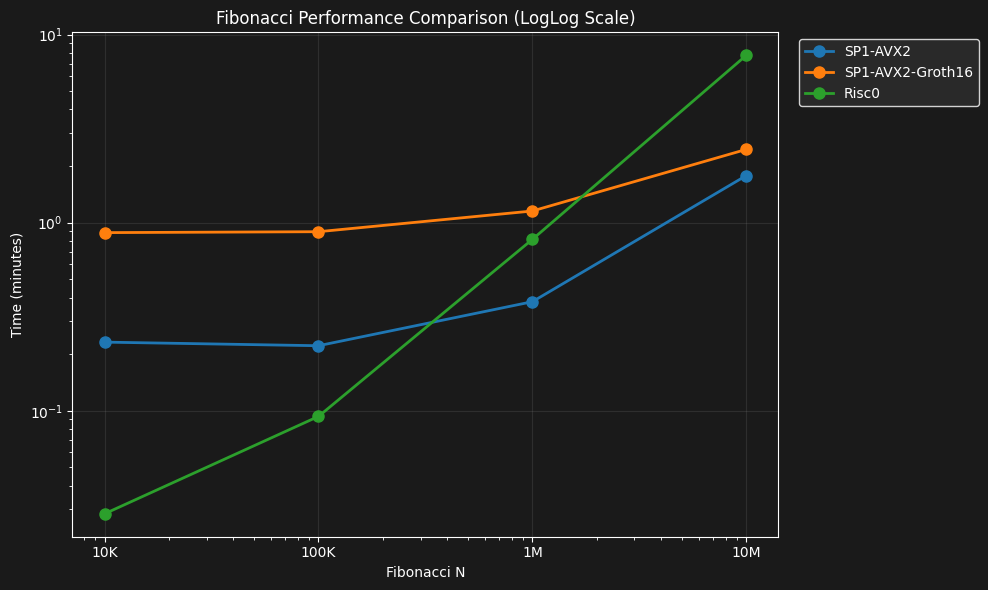

In [5]:
plot_data(df, 'Fibonacci N', 'Fibonacci')

##### Time used at biggest sample taken

In [6]:
show_max_sample_time(df, column='N (Millions)' ,factor=1_000_000)

,Prover,N (Millions),Time
9,SP1-AVX2,10.00,1m46.8s
10,SP1-AVX2-Groth16,10.00,2m27.1s
11,Risc0,10.00,7m45.5s


### Keccak Benchmark

In this section we will analyze the performance of Keccak for different provers.

#### Load the data

The data was loaded from `bench_results/keccak_6_mar_25_A6000.csv`.

In [7]:
input_csv_path = 'bench_results/keccak_6_mar_25_A6000.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [8]:
print_dataframe(df)


Data sorted by Prover and N for validation:
              Prover          N      Time  Minutes
2              Risc0        100      7.3s     0.12
5              Risc0       1000      7.5s     0.12
8              Risc0      10000     11.0s     0.18
11             Risc0     100000     43.5s     0.72
14             Risc0    1000000    6m8.0s     6.13
17             Risc0   10000000  64m31.4s    64.52
0           SP1-AVX2        100     21.5s     0.36
3           SP1-AVX2       1000     21.8s     0.36
6           SP1-AVX2      10000     22.0s     0.37
9           SP1-AVX2     100000     22.6s     0.38
12          SP1-AVX2    1000000     33.1s     0.55
15          SP1-AVX2   10000000   2m22.0s     2.37
18          SP1-AVX2  100000000  20m24.4s    20.41
1   SP1-AVX2-Groth16        100     57.2s     0.95
4   SP1-AVX2-Groth16       1000    1m2.6s     1.04
7   SP1-AVX2-Groth16      10000    1m1.6s     1.03
10  SP1-AVX2-Groth16     100000    1m2.6s     1.04
13  SP1-AVX2-Groth16    1000000   1m1

#### Data analytics

##### Plot: Log N vs Log Time

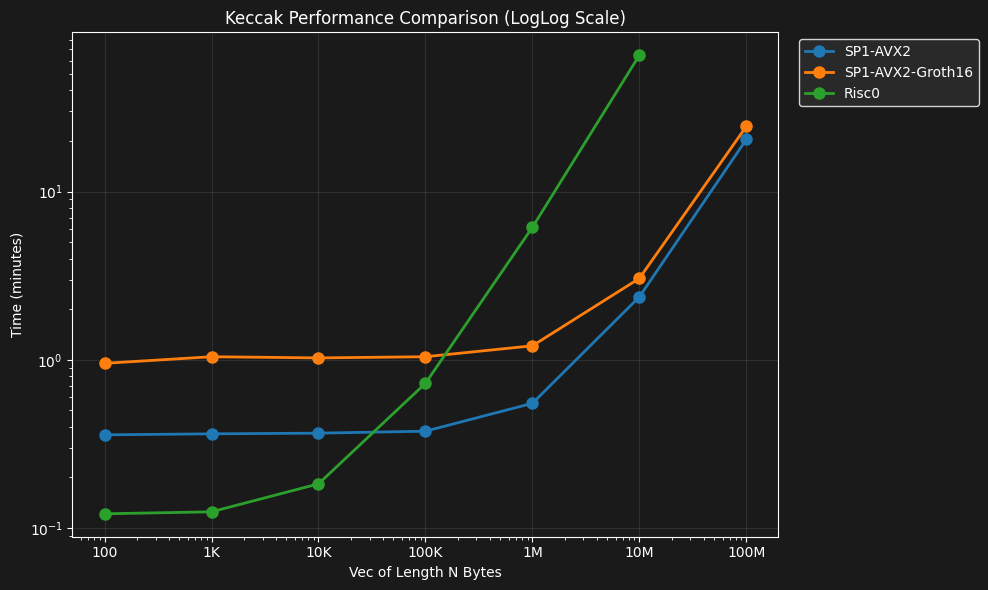

In [9]:
plot_data(df, 'Vec of Length N Bytes', 'Keccak')

##### KiB hased per second at max sample

In [10]:
calculate_kps(df)


KiB hased per second at max sample


,Prover,KiB/sec
0,SP1-AVX2,79.76
1,SP1-AVX2-Groth16,66.72
2,Risc0,2.52


##### Time used at 10M and 100M bytes

In [11]:
n1 = 10_000_000
n2 = 100_000_000

show_sample_at_n(df, n1, 'Bytes (Millions)')
show_sample_at_n(df, n2, 'Bytes (Millions)')

,Prover,Bytes (Millions),Time
15,SP1-AVX2,10.00,2m22.0s
16,SP1-AVX2-Groth16,10.00,3m2.9s
17,Risc0,10.00,64m31.4s


,Prover,Bytes (Millions),Time
18,SP1-AVX2,100.00,20m24.4s
19,SP1-AVX2-Groth16,100.00,24m23.7s


### RSP Benchmark

In this section we will analyze the performance of [RSP](https://github.com/succinctlabs/rsp) for different provers over blocks with different amounts of Gas.

Notice the cost is not purely lineal, since there can be blocks that require more keccaks and are more expensive to prove than others. For example, the block of 27Mgas is cheaper to prove than the one of 18M Gas


#### Load the data

The data was loaded from `bench_results/rsp_8_mar_25_A6000.csv`.

In [12]:
input_csv_path = 'bench_results/rsp_8_mar_25_A6000.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [13]:
print_dataframe(df)


Data sorted by Prover and N for validation:
       Prover   N         Time  Minutes
1   RSP RISC0   1      7m42.8s     7.71
3   RSP RISC0   3     21m16.7s    21.28
5   RSP RISC0   9     52m42.1s    52.70
7   RSP RISC0  18     90m28.9s    90.48
9   RSP RISC0  27     42m49.5s    42.83
11  RSP RISC0  36  218m29.419s   218.49
0     RSP SP1   1      2m30.1s     2.50
2     RSP SP1   3      7m28.3s     7.47
4     RSP SP1   9     20m42.4s    20.71
6     RSP SP1  18      35m8.2s    35.14
8     RSP SP1  27     12m54.5s    12.91
10    RSP SP1  36      55m8.5s    55.14


#### Data analytics

##### Plot: Log N vs Log Time

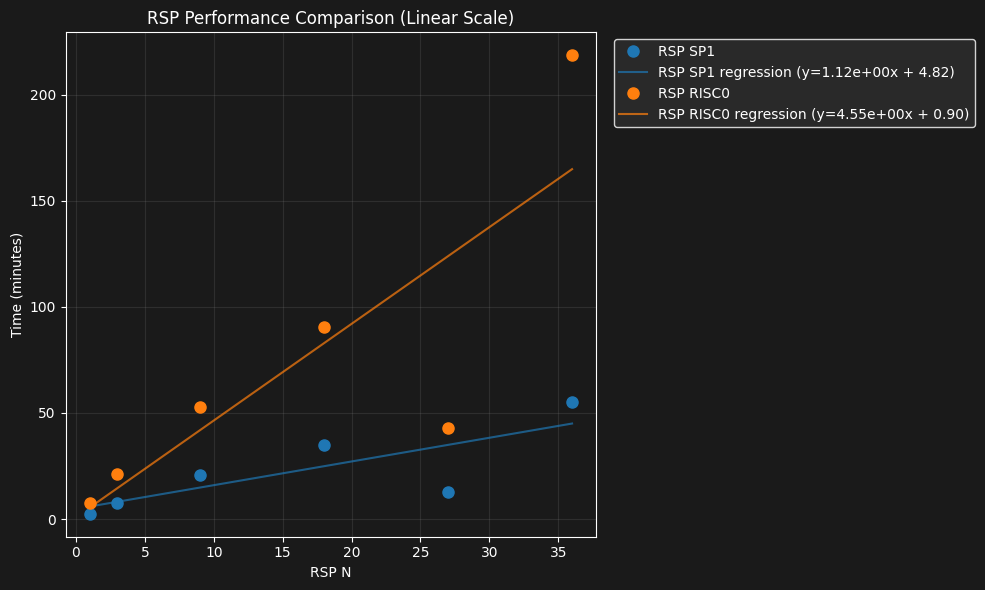

In [14]:
plot_data(df, 'RSP N', 'RSP', use_linear=True, use_regression=True)

Note: The 27Mgas block has fewer transactions than the other blocks, but one of them is a high cpu usage transaction.

##### Time used for a 36Mgas block

In [15]:
n1 = 36

show_sample_at_n(df, n1, column='Megagas', factor=1)

,Prover,Megagas,Time
10,RSP SP1,36.00,55m8.5s
11,RSP RISC0,36.00,218m29.419s


## CPU Benchmarks on AMD EPYC 8534P 64-Core Processor

The data was collected on a server with the following specs:

- CPU: AMD EPYC 8534P 64-Core Processor
- RAM: 576GB
- OS: Ubuntu 24 LTS

### Fibonacci Benchmark

In this section we will analyze the performance of Fibonacci for different provers.

#### Load the data

The data was loaded from `bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv`.

In [16]:
input_csv_path = 'bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [17]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                Prover        N     Time  Minutes
0          Pico-AVX512    10000    22.9s     0.38
4          Pico-AVX512   100000    35.5s     0.59
8          Pico-AVX512  1000000  1m46.0s     1.77
12         Pico-AVX512  4000000  5m18.6s     5.31
3                Risc0    10000    10.8s     0.18
7                Risc0   100000    50.9s     0.85
11               Risc0  1000000  7m53.1s     7.89
15               Risc0  4000000  31m2.0s    31.03
1           SP1-AVX512    10000    16.0s     0.27
5           SP1-AVX512   100000    34.0s     0.57
9           SP1-AVX512  1000000  1m42.8s     1.71
13          SP1-AVX512  4000000  5m21.2s     5.35
2   SP1-AVX512-Groth16    10000  1m18.5s     1.31
6   SP1-AVX512-Groth16   100000  1m36.4s     1.61
10  SP1-AVX512-Groth16  1000000  2m45.8s     2.76
14  SP1-AVX512-Groth16  4000000  6m29.4s     6.49


#### Data analytics

##### Plot: Log N vs Log Time

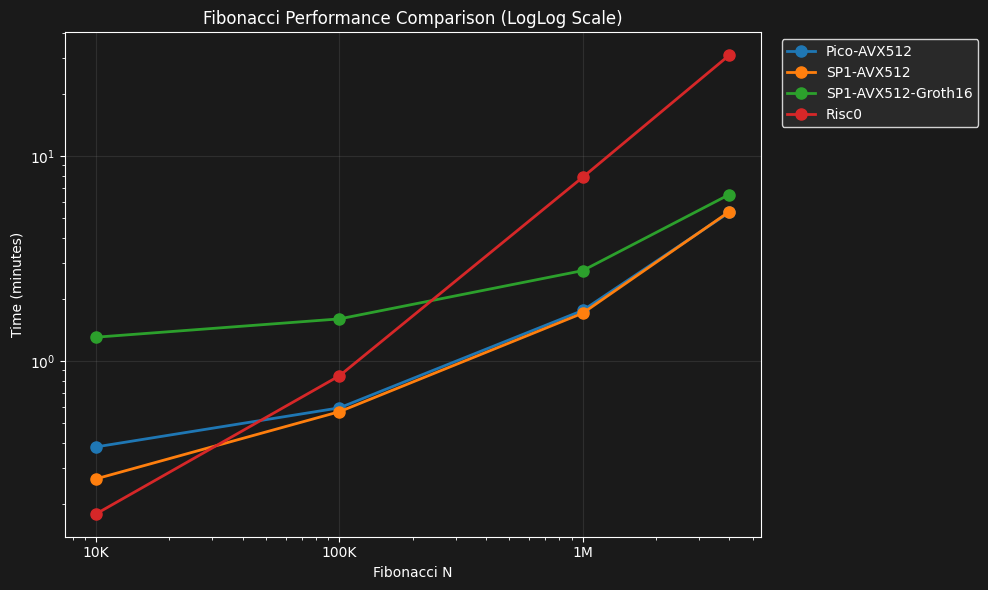

In [18]:
plot_data(df, 'Fibonacci N', 'Fibonacci')

##### Time used at biggest sample taken

In [19]:
show_max_sample_time(df)

,Prover,N,Time
12,Pico-AVX512,4.00,5m18.6s
13,SP1-AVX512,4.00,5m21.2s
14,SP1-AVX512-Groth16,4.00,6m29.4s
15,Risc0,4.00,31m2.0s


### Keccak Benchmark

In this section we will analyze the performance of Keccak for different provers.

#### Load the data

The data was loaded from `bench_results/keccak_5_mar_25_epyc8534p_64c_576gb.csv`.

In [20]:
input_csv_path = 'bench_results/keccak_5_mar_25_epyc8534p_64c_576gb.csv'
df = load_data(input_csv_path)

#### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [21]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                Prover         N      Time  Minutes
0          Pico-AVX512       100     28.8s     0.48
3          Pico-AVX512      1000     28.8s     0.48
6          Pico-AVX512     10000     29.8s     0.50
9          Pico-AVX512    100000     39.4s     0.66
12         Pico-AVX512   1000000   1m46.8s     1.78
15         Pico-AVX512  10000000  12m27.4s    12.46
18               Risc0       100     34.4s     0.57
19               Risc0      1000     37.1s     0.62
20               Risc0     10000    1m8.9s     1.15
21               Risc0    100000   6m19.7s     6.33
1           SP1-AVX512       100     53.5s     0.89
4           SP1-AVX512      1000     53.5s     0.89
7           SP1-AVX512     10000     53.3s     0.89
10          SP1-AVX512    100000    1m2.8s     1.05
13          SP1-AVX512   1000000   2m22.6s     2.38
16          SP1-AVX512  10000000  19m51.6s    19.86
2   SP1-AVX512-Groth16       100   1m56.0s     1.93
5   SP1-AVX512-Grot

#### Data analytics

##### Plot: Log N vs Log Time

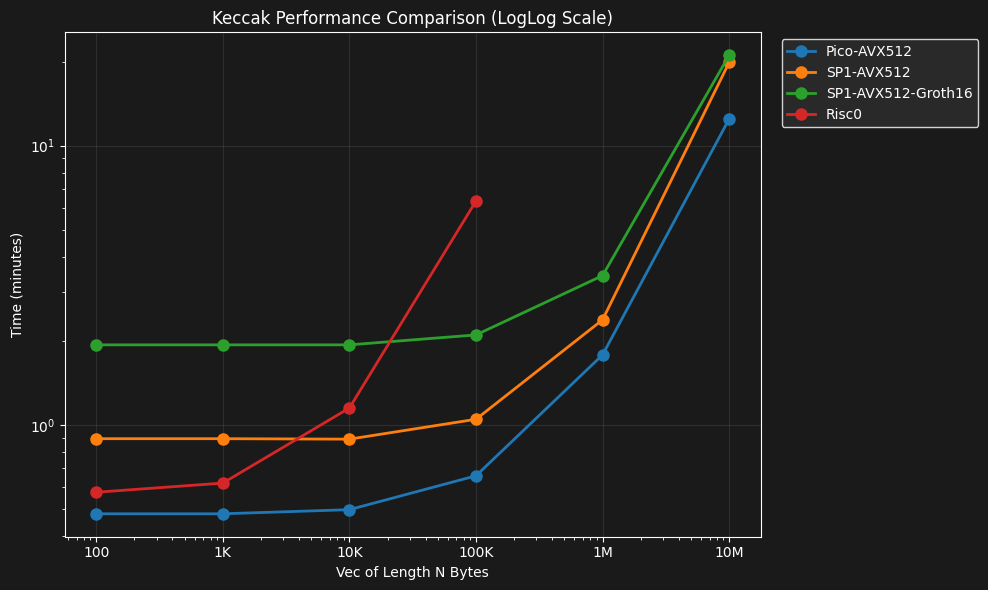

In [22]:
plot_data(df, 'Vec of Length N Bytes', 'Keccak')

##### KiB hased per second at max sample

In [23]:
calculate_kps(df)


KiB hased per second at max sample


,Prover,KiB/sec
0,Pico-AVX512,13.07
1,SP1-AVX512,8.20
2,SP1-AVX512-Groth16,7.73
3,Risc0,0.26


##### Time used at 100K bytes and 10M bytes

In [24]:
n1 = 100_000
n2 = 10_000_000

show_sample_at_n(df, n1)
show_sample_at_n(df, n2)

,Prover,N,Time
9,Pico-AVX512,0.10,39.4s
10,SP1-AVX512,0.10,1m2.8s
11,SP1-AVX512-Groth16,0.10,2m5.9s
21,Risc0,0.10,6m19.7s


,Prover,N,Time
15,Pico-AVX512,10.00,12m27.4s
16,SP1-AVX512,10.00,19m51.6s
17,SP1-AVX512-Groth16,10.00,21m3.5s
